In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from skimage.color import rgb2gray
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import ndimage
import os
import sys
import random
import math
import numpy as np
import skimage.io
import matplotlib
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive') 

Mounted at /content/drive


In [ ]:
train_sample_metadata = pd.read_json('/content/drive/MyDrive/Datasets/Dataset1/train_sample_videos/metadata.json').T
train_sample_metadata.head()

,label,split,original
aagfhgtpmv.mp4,FAKE,train,vudstovrck.mp4
aapnvogymq.mp4,FAKE,train,jdubbvfswz.mp4
abarnvbtwb.mp4,REAL,train,None
abofeumbvv.mp4,FAKE,train,atvmxvwyns.mp4
abqwwspghj.mp4,FAKE,train,qzimuostzz.mp4


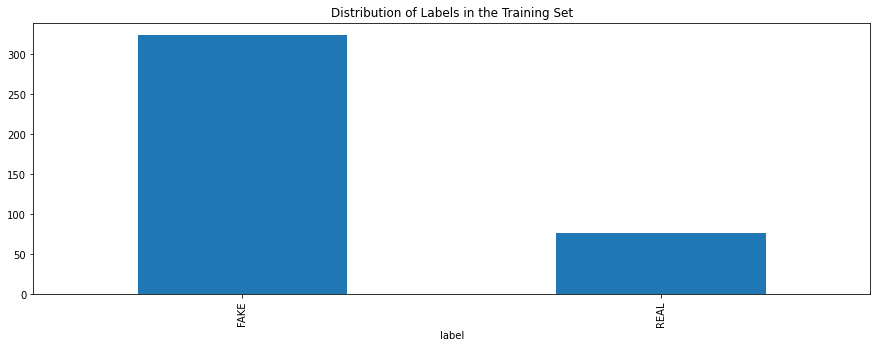

In [ ]:
train_sample_metadata.groupby('label')['label'].count().plot(figsize=(15, 5), kind='bar', title='Distribution of Labels in the Training Set')
plt.show()

In [ ]:
from IPython.display import HTML
from base64 import b64encode
vid1 = open('/content/drive/MyDrive/Datasets/Dataset1/test_videos/aassnaulhq.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(vid1).decode()
HTML(""" 
<video width=600 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
import glob
import cv2
from albumentations import *
from tqdm import tqdm_notebook as tqdm
import gc

from keras.models import Model as KerasModel
from keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Dropout, Reshape, Concatenate, LeakyReLU
from tensorflow.keras.optimizers import Adam
!pip3 install face_recognition
import face_recognition
import imageio
import tensorflow as tf

import warnings
warnings.filterwarnings('ignore')
# PATH = '/content/drive/MyDrive/Datasets/Dataset1/'
# print(os.listdir(PATH))

In [ ]:
# !pip install '/kaggle/input/dlibpkg/dlib-19.19.0'

In [ ]:
class Video:
    def __init__(self, path):
        self.path = path
        self.container = imageio.get_reader(path, 'ffmpeg')
        # self.length = self.container.count_frames()
        self.length = self.container.get_meta_data()['nframes']
        self.fps = self.container.get_meta_data()['fps']
    
    def init_head(self):
        self.container.set_image_index(0)
    
    def next_frame(self):
        self.container.get_next_data()
    
    def get(self, key):
        return self.container.get_data(key)
    
    def __call__(self, key):
        return self.get(key)
    
    def __len__(self):
        return self.length

In [ ]:
IMGWIDTH = 256

class Classifier:
    def __init__():
        self.model = 0
    
    def predict(self, x):
        return self.model.predict(x)
    
    def fit(self, x, y):
        return self.model.train_on_batch(x, y)
    
    def get_accuracy(self, x, y):
        return self.model.test_on_batch(x, y)
    
    def load(self, path):
        self.model.load_weights(path)


class Meso4(Classifier):
    def __init__(self, learning_rate = 0.001):
        self.model = self.init_model()
        optimizer = Adam(lr = learning_rate)
        self.model.compile(optimizer = optimizer, loss = 'mean_squared_error', metrics = ['accuracy'])
    
    def init_model(self): 
        x = Input(shape = (IMGWIDTH, IMGWIDTH, 3))
        
        x1 = Conv2D(8, (3, 3), padding='same', activation = 'relu')(x)
        x1 = BatchNormalization()(x1)
        x1 = MaxPooling2D(pool_size=(2, 2), padding='same')(x1)
        
        x2 = Conv2D(8, (5, 5), padding='same', activation = 'relu')(x1)
        x2 = BatchNormalization()(x2)
        x2 = MaxPooling2D(pool_size=(2, 2), padding='same')(x2)
        
        x3 = Conv2D(16, (5, 5), padding='same', activation = 'relu')(x2)
        x3 = BatchNormalization()(x3)
        x3 = MaxPooling2D(pool_size=(2, 2), padding='same')(x3)
        
        x4 = Conv2D(16, (5, 5), padding='same', activation = 'relu')(x3)
        x4 = BatchNormalization()(x4)
        x4 = MaxPooling2D(pool_size=(4, 4), padding='same')(x4)
        
        y = Flatten()(x4)
        y = Dropout(0.5)(y)
        y = Dense(16)(y)
        y = LeakyReLU(alpha=0.1)(y)
        y = Dropout(0.5)(y)
        y = Dense(1, activation = 'sigmoid')(y)

        return KerasModel(inputs = x, outputs = y)

class MesoInception4(Classifier):
    def __init__(self, learning_rate = 0.001):
        self.model = self.init_model()
        optimizer = Adam(lr = learning_rate)
        self.model.compile(optimizer = optimizer, loss = 'mean_squared_error', metrics = ['accuracy'])
    
    def InceptionLayer(self, a, b, c, d):
        def func(x):
            x1 = Conv2D(a, (1, 1), padding='same', activation='relu')(x)
            
            x2 = Conv2D(b, (1, 1), padding='same', activation='relu')(x)
            x2 = Conv2D(b, (3, 3), padding='same', activation='relu')(x2)
            
            x3 = Conv2D(c, (1, 1), padding='same', activation='relu')(x)
            x3 = Conv2D(c, (3, 3), dilation_rate = 2, strides = 1, padding='same', activation='relu')(x3)
            
            x4 = Conv2D(d, (1, 1), padding='same', activation='relu')(x)
            x4 = Conv2D(d, (3, 3), dilation_rate = 3, strides = 1, padding='same', activation='relu')(x4)

            y = Concatenate(axis = -1)([x1, x2, x3, x4])
            
            return y
        return func
    
    def init_model(self):
        x = Input(shape = (IMGWIDTH, IMGWIDTH, 3))
        
        x1 = self.InceptionLayer(1, 4, 4, 2)(x)
        x1 = BatchNormalization()(x1)
        x1 = MaxPooling2D(pool_size=(2, 2), padding='same')(x1)
        
        x2 = self.InceptionLayer(2, 4, 4, 2)(x1)
        x2 = BatchNormalization()(x2)
        x2 = MaxPooling2D(pool_size=(2, 2), padding='same')(x2)        
        
        x3 = Conv2D(16, (5, 5), padding='same', activation = 'relu')(x2)
        x3 = BatchNormalization()(x3)
        x3 = MaxPooling2D(pool_size=(2, 2), padding='same')(x3)
        
        x4 = Conv2D(16, (5, 5), padding='same', activation = 'relu')(x3)
        x4 = BatchNormalization()(x4)
        x4 = MaxPooling2D(pool_size=(4, 4), padding='same')(x4)
        
        y = Flatten()(x4)
        y = Dropout(0.5)(y)
        y = Dense(16)(y)
        y = LeakyReLU(alpha=0.1)(y)
        y = Dropout(0.5)(y)
        y = Dense(1, activation = 'sigmoid')(y)

        return KerasModel(inputs = x, outputs = y)

In [ ]:
tf.test.is_gpu_available(
    cuda_only=False,
    min_cuda_compute_capability=None
)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [ ]:
classifier = Meso4() 
classifier.load('/content/drive/MyDrive/Meso4_DF') 


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


prediction on the train set : 

probability of fake:

In [ ]:
video = Video("/content/drive/MyDrive/Datasets/Dataset1/train_sample_videos/aagfhgtpmv.mp4")
save_interval = 150 # perform face detection every {save_interval} frames
margin = 0.2
for i in range(0,video.__len__(),save_interval):
    img = video.get(i)
    face_positions = face_recognition.face_locations(img)
    for face_position in face_positions:
        offset = round(margin * (face_position[2] - face_position[0]))
        y0 = max(face_position[0] - offset, 0)
        x1 = min(face_position[1] + offset, img.shape[1])
        y1 = min(face_position[2] + offset, img.shape[0])
        x0 = max(face_position[3] - offset, 0)
        face = img[y0:y1,x0:x1]

        inp = cv2.resize(face,(256,256))/255.

        print(classifier.predict(np.array([inp])))

[[0.96697336]]
[[0.92422754]]


Dataset 1 prediction :

In [ ]:
c=[]
save_interval = 150 # perform face detection every {save_interval} frames
margin = 0.2
for vi in os.listdir('/content/drive/MyDrive/Datasets/Dataset1/test_videos'):
#     print(os.path.join("/kaggle/input/deepfake-detection-challenge/test_videos/", vi))
    re_video = 0.5
    try:
        video = Video(os.path.join("/content/drive/MyDrive/Datasets/Dataset1/test_videos/", vi))
        re_imgs = []
        for i in range(0,video.__len__(),save_interval):
            img = video.get(i)
            face_positions = face_recognition.face_locations(img)
            for face_position in face_positions:
                offset = round(margin * (face_position[2] - face_position[0]))
                y0 = max(face_position[0] - offset, 0)
                x1 = min(face_position[1] + offset, img.shape[1])
                y1 = min(face_position[2] + offset, img.shape[0])
                x0 = max(face_position[3] - offset, 0)
                face = img[y0:y1,x0:x1]

                inp = cv2.resize(face,(256,256))/255.
                re_img = classifier.predict(np.array([inp]))
                print(vi,": ",i , "  :  ",classifier.predict(np.array([inp])))
                re_imgs.append(re_img[0][0])
        re_video = np.average(re_imgs)
        if np.isnan(re_video):
            re_video = 0.5
    except:
        re_video = 0.5
        print("err")
    c.append([vi,1.0-re_video])

acazlolrpz.mp4 :  0   :   [[0.5973171]]
acazlolrpz.mp4 :  150   :   [[0.9220569]]
ahjnxtiamx.mp4 :  0   :   [[0.92425084]]
ahjnxtiamx.mp4 :  150   :   [[0.84640026]]
adohdulfwb.mp4 :  0   :   [[0.8850801]]
adohdulfwb.mp4 :  150   :   [[0.97163606]]
aayfryxljh.mp4 :  0   :   [[0.44072276]]
aayfryxljh.mp4 :  150   :   [[0.8321381]]
apvzjkvnwn.mp4 :  0   :   [[0.9047026]]
apvzjkvnwn.mp4 :  150   :   [[0.9036406]]
aomqqjipcp.mp4 :  0   :   [[0.9050715]]
aomqqjipcp.mp4 :  150   :   [[0.92416483]]
alrtntfxtd.mp4 :  150   :   [[0.4692037]]
apedduehoy.mp4 :  0   :   [[0.9668151]]
apedduehoy.mp4 :  150   :   [[0.4985559]]
ajiyrjfyzp.mp4 :  0   :   [[0.95671976]]
ajiyrjfyzp.mp4 :  150   :   [[0.6217736]]
aktnlyqpah.mp4 :  0   :   [[0.90324736]]
aktnlyqpah.mp4 :  150   :   [[0.8475521]]
ayipraspbn.mp4 :  0   :   [[0.35417536]]
ayipraspbn.mp4 :  150   :   [[0.27244696]]
bcvheslzrq.mp4 :  0   :   [[0.7740281]]
bcvheslzrq.mp4 :  150   :   [[0.5897454]]
axfhbpkdlc.mp4 :  0   :   [[0.8563629]]
axfhbpk

In [ ]:
ce = pd.DataFrame(c, columns=['filename', 'label']).fillna(0.5)
# ce = ce.drop([400,401,402])
ce.sort_values('filename').to_csv('results.csv', index=False)

In [ ]:
ce

,filename,label
0,acazlolrpz.mp4,0.240313
1,ahjnxtiamx.mp4,0.114674
2,adohdulfwb.mp4,0.071642
3,aassnaulhq.mp4,0.500000
4,aayfryxljh.mp4,0.363570
...,...,...
395,zuwwbbusgl.mp4,0.549093
396,zmxeiipnqb.mp4,0.445457
397,ztyvglkcsf.mp4,0.041102
398,ztyuiqrhdk.mp4,0.500000


Dataset2 prediction :

In [ ]:
c1=[]
save_interval = 150 # perform face detection every {save_interval} frames
margin = 0.2
for vi in os.listdir('/content/drive/MyDrive/Dataset2'):
    re_video = 0.5
    try:
        video = Video(os.path.join("/content/drive/MyDrive/Dataset2/", vi))
        re_imgs = []
        for i in range(0,video.__len__(),save_interval):
            img = video.get(i)
            face_positions = face_recognition.face_locations(img)
            for face_position in face_positions:
                offset = round(margin * (face_position[2] - face_position[0]))
                y0 = max(face_position[0] - offset, 0)
                x1 = min(face_position[1] + offset, img.shape[1])
                y1 = min(face_position[2] + offset, img.shape[0])
                x0 = max(face_position[3] - offset, 0)
                face = img[y0:y1,x0:x1]

                inp = cv2.resize(face,(256,256))/255.
                re_img = classifier.predict(np.array([inp]))
                print(vi,": ",i , "  :  ",classifier.predict(np.array([inp])))
                re_imgs.append(re_img[0][0])
        re_video = np.average(re_imgs)
        if np.isnan(re_video):
            re_video = 0.5
    except:
        re_video = 0.5
        print("err")
    c1.append([vi,1.0-re_video])

kliqnhmoxd.mp4 :  0   :   [[0.95244676]]
kliqnhmoxd.mp4 :  150   :   [[0.8636541]]
knfxukpgcm.mp4 :  0   :   [[0.9310718]]
kmzlyhldkp.mp4 :  0   :   [[0.87086743]]
kmzlyhldkp.mp4 :  150   :   [[0.5878128]]
kmquivkgue.mp4 :  0   :   [[0.07169592]]
knhmlrxtxi.mp4 :  0   :   [[0.27174938]]
korpsbxqcv.mp4 :  150   :   [[0.66882783]]
knwnqrvira.mp4 :  0   :   [[0.30120203]]
kpxujltitc.mp4 :  150   :   [[0.6314318]]
kpsxbmwfyv.mp4 :  0   :   [[0.2141894]]
kpsxbmwfyv.mp4 :  150   :   [[0.47350848]]
krpcvryehy.mp4 :  0   :   [[0.05047442]]
krpcvryehy.mp4 :  150   :   [[0.11628822]]
ktcjlrxium.mp4 :  0   :   [[0.23161548]]
ktikdxgsun.mp4 :  0   :   [[0.99002296]]
ktikdxgsun.mp4 :  150   :   [[0.981375]]
kumfnjadhi.mp4 :  0   :   [[0.89422905]]
kumfnjadhi.mp4 :  150   :   [[0.90727925]]
err
kvpgwfudix.mp4 :  0   :   [[0.2905612]]
kvpgwfudix.mp4 :  150   :   [[0.13833335]]
kvfvqoyoff.mp4 :  0   :   [[0.8995307]]
kvmpmhdxly.mp4 :  0   :   [[0.6236939]]
kvnxcfkctx.mp4 :  0   :   [[0.12850462]]
kvsn

In [ ]:
ce1 = pd.DataFrame(c1, columns=['filename', 'label']).fillna(0.5)
ce1.sort_values('filename').to_csv('results2.csv', index=False)

In [ ]:
ce1

,filename,label
0,klumuemvpu.mp4,0.500000
1,kmqkiihrmj.mp4,0.500000
2,kliqnhmoxd.mp4,0.091950
3,klhpomwpzs.mp4,0.500000
4,knfxukpgcm.mp4,0.068928
...,...,...
1695,kjmmkusnvx.mp4,0.996209
1696,kkjzeflvui.mp4,0.500000
1697,kkxtcywtrn.mp4,0.530302
1698,klcgzimbce.mp4,0.500000


0.500000    852
0.502476      1
0.338815      1
0.456500      1
0.150815      1
           ... 
0.550992      1
0.944192      1
0.284604      1
0.341886      1
0.530302      1
Name: label, Length: 849, dtype: int64

Dataset 3 prediction :

In [ ]:
c21=[]
save_interval = 150 # perform face detection every {save_interval} frames
margin = 0.2
for vi in os.listdir('/content/drive/MyDrive/Dataset3/dfdc_train_part_0'):
#     print(os.path.join("/kaggle/input/deepfake-detection-challenge/test_videos/", vi))
    re_video = 0.5
    try:
        video = Video(os.path.join("/content/drive/MyDrive/Dataset3/dfdc_train_part_0/", vi))
        re_imgs = []
        for i in range(0,video.__len__(),save_interval):
            img = video.get(i)
            face_positions = face_recognition.face_locations(img)
            for face_position in face_positions:
                offset = round(margin * (face_position[2] - face_position[0]))
                y0 = max(face_position[0] - offset, 0)
                x1 = min(face_position[1] + offset, img.shape[1])
                y1 = min(face_position[2] + offset, img.shape[0])
                x0 = max(face_position[3] - offset, 0)
                face = img[y0:y1,x0:x1]

                inp = cv2.resize(face,(256,256))/255.
                re_img = classifier.predict(np.array([inp]))
                print(vi,": ",i , "  :  ",classifier.predict(np.array([inp])))
                re_imgs.append(re_img[0][0])
        re_video = np.average(re_imgs)
        if np.isnan(re_video):
            re_video = 0.5
    except:
        re_video = 0.5
        print("err")
    c21.append([vi,1.0-re_video])

gvlraqlweh.mp4 :  0   :   [[0.11339616]]
gvlraqlweh.mp4 :  150   :   [[0.71623826]]
gwsmeakcic.mp4 :  150   :   [[0.5228496]]
gwzfugbidx.mp4 :  150   :   [[0.3285679]]
gvcrwbnzpa.mp4 :  150   :   [[0.58603483]]
gxonqiyzpk.mp4 :  0   :   [[0.4803863]]
gxonqiyzpk.mp4 :  150   :   [[0.22307591]]
gzkggvloao.mp4 :  0   :   [[0.10468492]]
gzkggvloao.mp4 :  150   :   [[0.23416728]]
gyrdgpiygb.mp4 :  0   :   [[0.774828]]
gyrdgpiygb.mp4 :  150   :   [[0.4828968]]
gyosvoeamf.mp4 :  0   :   [[0.50614154]]
gyosvoeamf.mp4 :  150   :   [[0.678316]]
hbdvyzpqny.mp4 :  0   :   [[0.84792066]]
hbdvyzpqny.mp4 :  150   :   [[0.8319562]]
hbtcuqhwyy.mp4 :  0   :   [[0.3707977]]
hbtcuqhwyy.mp4 :  150   :   [[0.5743282]]
hcanfkwivl.mp4 :  0   :   [[0.80189717]]
hcanfkwivl.mp4 :  150   :   [[0.9526082]]
hclsparpth.mp4 :  0   :   [[0.9831957]]
hclsparpth.mp4 :  150   :   [[0.55879515]]
hcqxrwzgxt.mp4 :  0   :   [[0.98786074]]
hcqxrwzgxt.mp4 :  150   :   [[0.7709668]]
hefisnapds.mp4 :  0   :   [[0.476439]]
hdgfgv

In [ ]:
ce21 = pd.DataFrame(c21, columns=['filename', 'label']).fillna(0.5)
ce21.sort_values('filename').to_csv('results31.csv', index=False)

In [ ]:
c22=[]
save_interval = 150 # perform face detection every {save_interval} frames
margin = 0.2
for vi in os.listdir('/content/drive/MyDrive/Dataset3/dfdc_train_part_3'):
#     print(os.path.join("/kaggle/input/deepfake-detection-challenge/test_videos/", vi))
    re_video = 0.5
    try:
        video = Video(os.path.join("/content/drive/MyDrive/Dataset3/dfdc_train_part_3/", vi))
        re_imgs = []
        for i in range(0,video.__len__(),save_interval):
            img = video.get(i)
            face_positions = face_recognition.face_locations(img)
            for face_position in face_positions:
                offset = round(margin * (face_position[2] - face_position[0]))
                y0 = max(face_position[0] - offset, 0)
                x1 = min(face_position[1] + offset, img.shape[1])
                y1 = min(face_position[2] + offset, img.shape[0])
                x0 = max(face_position[3] - offset, 0)
                face = img[y0:y1,x0:x1]

                inp = cv2.resize(face,(256,256))/255.
                re_img = classifier.predict(np.array([inp]))
                print(vi,": ",i , "  :  ",classifier.predict(np.array([inp])))
                re_imgs.append(re_img[0][0])
        re_video = np.average(re_imgs)
        if np.isnan(re_video):
            re_video = 0.5
    except:
        re_video = 0.5
        print("err")
    c22.append([vi,1.0-re_video])

ifzspsyvsu.mp4 :  0   :   [[0.38653418]]
ifzspsyvsu.mp4 :  150   :   [[0.3610088]]
ieblyetiob.mp4 :  0   :   [[0.46604902]]
ieblyetiob.mp4 :  150   :   [[0.58035564]]
iarkaikbkj.mp4 :  0   :   [[0.3176006]]
iarkaikbkj.mp4 :  150   :   [[0.18287626]]
icsxletuwy.mp4 :  150   :   [[0.24550341]]
idxqdzkedj.mp4 :  0   :   [[0.44797042]]
idxqdzkedj.mp4 :  150   :   [[0.05632716]]
icbqfvgfsm.mp4 :  0   :   [[0.5101416]]
icbqfvgfsm.mp4 :  150   :   [[0.49922344]]
idlvayiwru.mp4 :  0   :   [[0.92847633]]
idlvayiwru.mp4 :  150   :   [[0.91232944]]
ifraezsjlu.mp4 :  150   :   [[0.69535905]]
iidlzxipln.mp4 :  0   :   [[0.44628355]]
iidlzxipln.mp4 :  150   :   [[0.47147956]]
ijykzqouhx.mp4 :  0   :   [[0.22296783]]
ijykzqouhx.mp4 :  150   :   [[0.14175998]]
ihgiutlmbw.mp4 :  0   :   [[0.20670715]]
ihgiutlmbw.mp4 :  150   :   [[0.3454134]]
imtxzghzev.mp4 :  0   :   [[0.44143102]]
imtxzghzev.mp4 :  150   :   [[0.6172517]]
infnnslrwc.mp4 :  0   :   [[0.43455213]]
infnnslrwc.mp4 :  150   :   [[0.255826

In [ ]:
ce22 = pd.DataFrame(c22, columns=['filename', 'label']).fillna(0.5)
ce22.sort_values('filename').to_csv('results32.csv', index=False)

In [ ]:
c23=[]
save_interval = 150 # perform face detection every {save_interval} frames
margin = 0.2
for vi in os.listdir('/content/drive/MyDrive/Dataset3/dfdc_train_part_4'):
#     print(os.path.join("/kaggle/input/deepfake-detection-challenge/test_videos/", vi))
    re_video = 0.5
    try:
        video = Video(os.path.join("/content/drive/MyDrive/Dataset3/dfdc_train_part_4/", vi))
        re_imgs = []
        for i in range(0,video.__len__(),save_interval):
            img = video.get(i)
            face_positions = face_recognition.face_locations(img)
            for face_position in face_positions:
                offset = round(margin * (face_position[2] - face_position[0]))
                y0 = max(face_position[0] - offset, 0)
                x1 = min(face_position[1] + offset, img.shape[1])
                y1 = min(face_position[2] + offset, img.shape[0])
                x0 = max(face_position[3] - offset, 0)
                face = img[y0:y1,x0:x1]

                inp = cv2.resize(face,(256,256))/255.
                re_img = classifier.predict(np.array([inp]))
                print(vi,": ",i , "  :  ",classifier.predict(np.array([inp])))
                re_imgs.append(re_img[0][0])
        re_video = np.average(re_imgs)
        if np.isnan(re_video):
            re_video = 0.5
    except:
        re_video = 0.5
        print("err")
    c23.append([vi,1.0-re_video])

koayhruklm.mp4 :  0   :   [[0.6853755]]
koayhruklm.mp4 :  150   :   [[0.9647028]]
kmcylsrkvl.mp4 :  150   :   [[0.2637728]]
knzapnazlb.mp4 :  0   :   [[0.5838965]]
knzapnazlb.mp4 :  150   :   [[0.6721782]]
kpfqvgmnzw.mp4 :  0   :   [[0.4405944]]
kpfqvgmnzw.mp4 :  150   :   [[0.4816875]]
kpfqvgmnzw.mp4 :  150   :   [[0.12070583]]
kqkblcxaas.mp4 :  0   :   [[0.11848933]]
kqkblcxaas.mp4 :  150   :   [[0.2251833]]
kqkblcxaas.mp4 :  150   :   [[0.9907088]]
kputxwfoxd.mp4 :  0   :   [[0.34368148]]
kputxwfoxd.mp4 :  150   :   [[0.5608337]]
kqnuloxwny.mp4 :  0   :   [[0.6527677]]
kqnuloxwny.mp4 :  150   :   [[0.86888045]]
kohvzfkpqb.mp4 :  0   :   [[0.2720763]]
kqfhsniyug.mp4 :  150   :   [[0.4891392]]
krvbwmboog.mp4 :  0   :   [[0.8506505]]
krvbwmboog.mp4 :  150   :   [[0.9464733]]
krfzimyfws.mp4 :  0   :   [[0.17549664]]
krfzimyfws.mp4 :  150   :   [[0.5703377]]
krviialzvc.mp4 :  0   :   [[0.44733635]]
krviialzvc.mp4 :  150   :   [[0.42447245]]
krviialzvc.mp4 :  150   :   [[0.5528394]]
krxnd

In [ ]:
ce23 = pd.DataFrame(c23, columns=['filename', 'label']).fillna(0.5)
ce23.sort_values('filename').to_csv('results33.csv', index=False)

In [ ]:
import pandas as pd
files1 = '/content/drive/MyDrive/Deep fake using MesoNet final/results31.csv'
files2 ='/content/drive/MyDrive/Deep fake using MesoNet final/results32.csv'
files3 ='/content/drive/MyDrive/Deep fake using MesoNet final/results33.csv'
f = pd.concat(
   map(pd.read_csv, [files1, files2]), ignore_index=True)
f.to_csv("result3.csv" ,index=False)

In [ ]:
file4 = '/content/result3.csv'

In [ ]:
ft = pd.concat(
   map(pd.read_csv, [files3 ,file4]), ignore_index=False)

In [ ]:
ft

,filename,label
0,aaaoqepxnf.mp4,0.114011
1,aahncigwte.mp4,0.935566
2,abfvpzjkwr.mp4,0.210925
3,abiodyryai.mp4,0.080885
4,acgywoqfbr.mp4,0.641182
...,...,...
2786,zxrrlzkgwj.mp4,0.605994
2787,zzgtpnamdc.mp4,0.558466
2788,zznanrtksj.mp4,0.849037
2789,zzogukbedf.mp4,0.211560


In [ ]:
ft.to_csv("results3.csv" , index =False)